# Recursive Neural Network

In [2]:
import sys
import theano
import theano.tensor as T
import numpy as np
import string
import matplotlib.pyplot as plt
import json
import nltk
import operator
from nltk import pos_tag, word_tokenize
from sklearn.utils import shuffle
from datetime import datetime
from nltk.corpus import brown

In [39]:
def init_weights(Mi, Mo):
    return np.random.randn(Mi, Mo) / np.sqrt(Mi + Mo)

In [94]:
class RecursiveNN(object):
    def __init__(self, V, D, K):
        self.V = V
        self.D = D
        self.K = K
        
    def set_forward(self, We, Wh, bh, Wo, bo, activation):
        
        self.f = activation
            
        self.We = theano.shared(We)
        self.Wh = theano.shared(Wh)
        self.bh = theano.shared(bh)
        self.Wo = theano.shared(Wo)
        self.bo = theano.shared(bo)
        self.params = [self.We, self.Wh, self.bh, self.Wo, self.bo]
            
        # create input training vectors
        # NOTE: 
        # the words vector actually represents nodes in the original parse tree
        # Each element in words vector can either be a leave node containing a word 
        # or inner node
        words = T.ivector('words')
        parents = T.ivector('parents')
        relations = T.ivector('relations')
        labels = T.ivector('labels')
        
        def recurrence(n, hiddens, words, parents, relations):
          
            w = words[n]
        
            # update hidden matrix for current node
            hiddens = T.switch(
                T.ge(w, 0),
                T.set_subtensor(hiddens[n], self.We[w]),
                T.set_subtensor(hiddens[n], self.f(hiddens[n] + self.bh)),
            )
            
            # update hidden matrix for parent node
            p = parents[n]
            r = relations[n]
            hiddens = T.switch(
                T.ge(p, 0),
                T.set_subtensor(hiddens[p], hiddens[p] + hiddens[n].dot(self.Wh[r])),
                hiddens,
            )
            
            return hiddens
        
        # initialize hidden matrix
        # IMPORTANT: each row of the hidden matrix represents a node in the original parse tree
        # it can be leave node containing word or inner node
        hiddens = T.zeros((words.shape[0], self.D))
        
        h, _ = theano.scan(
            fn=recurrence,
            sequences=T.arange(words.shape[0]),
            n_steps=words.shape[0],
            outputs_info=[hiddens],
            non_sequences=[words, parents, relations],
        )
        
        # note we use T.arange not python's range and use T.zeros not np.zeros below
        
        # symbolic expression of the output probablility distribution
        py_x = T.nnet.softmax(h[-1].dot(self.Wo) + self.bo)
        prediction = T.argmax(py_x, axis=1)
        
        self.prediction_op = theano.function(
            inputs = [words, parents, relations],
            outputs = prediction,
            allow_input_downcast=True,
        )
        
        return words, parents, relations, labels, py_x, prediction
        
        
    def fit(self, trees, t_trees, learning_rate=1e-3, reg=1e-2, mu=0.99, eps=1e-2, decay_rate=0.999, epochs=20, 
            activation=T.nnet.relu):
        
        print("learning rate:", learning_rate)
        print("regularization:", reg)
        print("mu:", mu)
        print("eps:", eps)
        print("epochs:", epochs)
        print("decay_rate:", decay_rate)
        print("dim:", self.D)
        print("train_inner_nodes: ", train_inner_nodes)
        
        V = self.V
        D = self.D
        K = self.K
        R = 2
        N = len(trees)
        
        ### initialize weights
        
        We = init_weights(V, D)
        
        Wh = np.random.randn(R, D, D) / np.sqrt(R + D + D)
        bh = np.zeros(D)
        
        Wo = init_weights(D, K)
        bo = np.zeros(K)
        
        ################################################
        ###  Prediction through forward propagation  ###
        ################################################
        
        words, parents, relations, labels, py_x, prediction = self.set_forward(We, Wh, bh, Wo, bo, activation)
            
        ############################################
        ###  Define Cross Entropy and Optimizer  ###
        ############################################
        
        # regularization cost
        rcost = reg*T.mean([(p*p).sum() for p in self.params])
        
        xentropy = -T.mean(T.log(py_x[-1, labels[-1]]))
        acost = xentropy + rcost
        
        grads = T.grad(acost, self.params)
        
        ### I tried different optimization approaches here
        
        # momentum
#         dparams = [theano.shared(p.get_value()*0) for p in self.params]
#         updates = [
#             (p, p + mu*dp - learning_rate*g) for p, dp, g in zip(self.params, dparams, grads)
#         ] + [
#             (dp, mu*dp - learning_rate*g) for dp, g in zip(dparams, grads)
#         ]
        
        # AdaGrad
        
        caches = [theano.shared(np.ones_like(p.get_value())) for p in self.params]
        new_caches = [c + g*g for c, g in zip(caches, grads)]

        c_update = [(c, new_c) for c, new_c in zip(caches, new_caches)]
        g_update = [
          (p, p - learning_rate*g / T.sqrt(new_c + eps)) for p, new_c, g in zip(self.params, new_caches, grads)
        ]
        
        # does the order of updates matter???
        updates = c_update + g_update
    
        # RMSprop (does not work! why???)
#         cache = [theano.shared(p.get_value()*0) for p in self.params]
#         updates = [
#             (c, decay_rate * c + (1 - decay_rate)*g*g) for c, g in zip(cache, grads)
#         ] + [
#             (p, p - learning_rate*g / (T.sqrt(c) + eps)) for p, c, g in zip(self.params, cache, grads)
#         ]


        # RMSprop + momentum
#         dparams = [theano.shared(p.get_value()*0) for p in self.params]
#         cache = [theano.shared(p.get_value()*0) for p in self.params]
#         updates = [
#             (c, decay_rate * c + (1 - decay_rate)*g*g) for c, g in zip(cache, grads)
#         ] + [
#             (dp, mu*dp - learning_rate*g / (T.sqrt(c) + eps)) for dp, c, g in zip(dparams, cache, grads)
#         ] + [
#             (p, p + dp) for p, dp in zip(self.params, dparams)
#         ]
        
        self.train_op = theano.function(
            inputs = [words, parents, relations, labels],
            outputs = [xentropy, acost, prediction],
            updates=updates,
            allow_input_downcast=True,
        ) 
        
        
        ################################################
        ###  Start Training through Backpropagation  ###
        ################################################
        
        ### start training
        print("start training...")
        
        costs = []
        xents = []
        sequence_indexes = range(N)
        if train_inner_nodes:
            n_total = sum(len(words) for words, _, _, _ in trees)
        else:
            n_total = N
            
        best_validation_score = 0
        for i in range(epochs):
            t0 = datetime.now()
            sequence_indexes = shuffle(sequence_indexes)
            n_correct = 0
            cost = 0
            xent = 0
            it = 0 # iteration count
            for j in sequence_indexes:
                words, parents, relations, labels = trees[j]
                xe, c, p = self.train_op(words, parents, relations, labels)
                
                if np.isnan(c):
                    print("Cost is nan! Let's stop here. Why don't you try decreasing the learning rate?")
                    exit()
                    
                cost += c
                xent += xe
                if train_inner_nodes:
                    n_correct += np.sum(p == labels)
                else:
                    n_correct += (p[-1] == labels[-1])
                it+=1
                if it % 1 == 0:
                    sys.stdout.write("epoch: %d, j/N: %d/%d correct rate so far: %f, cost so far: %f, xent so far: %f\r" % (i, it, N, float(n_correct)/n_total, cost, xent))
                    sys.stdout.flush()
            
            print("i:", i, "cost:", cost, "xent", xent, 
                  "correct rate:", (float(n_correct)/n_total), 
                  "time for epoch:", (datetime.now() - t0))
            val_score = self.score(t_trees[:1000])
#             best_validation_score = max(best_validation_score, val_score)
            if val_score > best_validation_score:
                best_validation_score = val_score
                self.save("./data/best_model.npz")
                print ("Saved best model")
                
            print ("val accuracy:", val_score, "best val accuracy so far:", best_validation_score)
            costs.append(cost)
            xents.append(xent)
        
        print ("best test accuracy:", best_validation_score)
        plt.plot(costs)
        plt.title("cost")
        plt.show()
        
        plt.plot(xents)
        plt.title("cross entropy")
        plt.show()
        
    def score(self, trees):
        n_total = len(trees)
        n_correct = 0
        for words, parents, relations, labels in trees:
            p = self.prediction_op(words, parents, relations)
            n_correct += (p[-1] == labels[-1])
        print("n_correct:", n_correct, "n_total:", n_total)
        return float(n_correct) / n_total
    
    def f1_score(self, trees):
        Y = []
        P = []
        for words, left, right, lab in trees:
            p = self.prediction_op(words, left, right)
            Y.append(lab[-1])
            P.append(p[-1])
        return f1_score(Y, P, average=None).mean()
    
    def save(self, filename):
        np.savez(filename, *[p.get_value() for p in self.params])

In [41]:
def load_model(filename, activation):
    npz = np.load(filename)
    We = npz['arr_0']
    Wh = npz['arr_1']
    bh = npz['arr_2']
    Wo = npz['arr_3']
    bo = npz['arr_4']
        
    V, D = We.shape
    _, K = Wo.shape
    rnn = RecursiveNN(V, D, K)
    rnn.set_forward(We, Wh, bh, Wo, bo, activation)
    return rnn

In [42]:
def load_data(data_file=None):
    if data_file == None:
        return
    with open(data_file) as f:
        data = json.load(f)
    return data

In [43]:
folder = './data/large_files/stanford_sentiment/parsed_data/'
word2idx = load_data(folder + "sentiment_word2idx.json")
sentiment_binary_train = load_data(folder + "sentiment_binary_train.json")
sentiment_train = load_data(folder + "sentiment_train.json")
sentiment_binary_test = load_data(folder + "sentiment_binary_test.json")
sentiment_test = load_data(folder + "sentiment_test.json")

print(len(sentiment_binary_train))
print(len(sentiment_binary_test))
print("Load data finished")

8544
2210
Load data finished


In [102]:
def main(train, val, word2idx, dim=10, learning_rate=1e-2, reg=1e-2, 
         mu=0, eps=1e-2, activation=T.tanh, epochs=30):
    
    # Exclude training and validation examples with negative label value
    train = [t for t in train if t[3][-1] >=0]
    val = [t for t in val if t[3][-1] >=0]
    
    train = shuffle(train)
    val = shuffle(val)
    
    # V is the number of words in the vocabulary
    V = len(word2idx)
    print("vocab size:", V)
    
    # is the hidden state dimension
    D = dim
    
    # K is the number of classes
    K = 2
    
    model = RecursiveNN(V, D, K)
    model.fit(train, val, learning_rate=learning_rate, reg=reg, mu=mu, eps=eps, epochs=epochs, activation=activation)
    print ("train accuracy:", model.score(train))
    print ("val accuracy:", model.score(val))
    

In [128]:
train = list(sentiment_binary_train.values()) 
test = list(sentiment_binary_test.values()) 
print(len(train))
print(len(test))
print("preprocess data finished")

8544
2210
preprocess data finished


In [129]:
val = test[:1000]
# test = test[1300:]
test = test[1000:]
print(len(train))
print(len(val))
print(len(test))

8544
1000
1210


vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 35
decay_rate: 0.999
dim: 10
train_inner_nodes:  False
start training...
i: 0 cost: 5371.95617564899 xent 5122.9364390407445 correct rate: 0.5195085729715134 time for epoch: 0:07:20.875845
n_correct: 416 n_total: 816
Saved best model
val accuracy: 0.5098039215686274 best val accuracy so far: 0.5098039215686274
i: 1 cost: 5279.3765463729505 xent 5115.221496404574 correct rate: 0.5243688402862158 time for epoch: 0:06:05.635528
n_correct: 419 n_total: 816
Saved best model
val accuracy: 0.5134803921568627 best val accuracy so far: 0.5134803921568627
i: 2 cost: 5226.982641256896 xent 5113.515048339073 correct rate: 0.5255839071148913 time for epoch: 0:07:14.653984
n_correct: 419 n_total: 816
val accuracy: 0.5134803921568627 best val accuracy so far: 0.5134803921568627
i: 3 cost: 5194.163899761024 xent 5112.029016291728 correct rate: 0.5290941001755096 time for epoch: 0:06:48.219996
n_correct: 419 n_total: 8

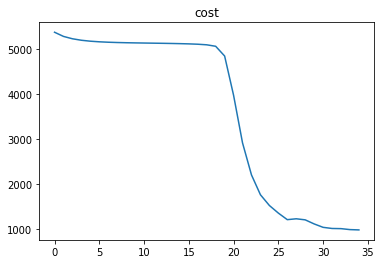

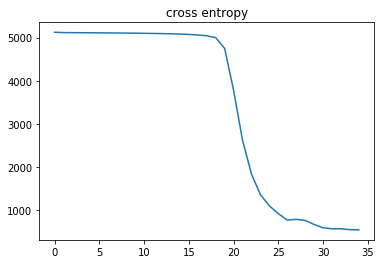

n_correct: 7333 n_total: 7407
train accuracy: 0.9900094505197786
n_correct: 696 n_total: 816
val accuracy: 0.8529411764705882


In [103]:
main(train, val, word2idx, dim=10, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=35)

In [117]:
model2 = load_model("./data/best_model.npz", T.tanh)
test2 = [t for t in test if t[3][-1] >=0]
val_score2 = model2.score(test2)
print("accuracy:", val_score2)

n_correct: 671 n_total: 816
accuracy: 0.82230392


vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 30
decay_rate: 0.999
dim: 10
train_inner_nodes:  False
start training...
i: 0 cost: 5055.345022384018 xent 4812.452914923927 correct rate: 0.5247738043946575 time for epoch: 0:06:36.955868
n_correct: 424 n_total: 816
Saved best model
val accuracy: 0.5196078431372549 best val accuracy so far: 0.5196078431372549
i: 1 cost: 4972.282960546299 xent 4802.755552354358 correct rate: 0.5437311503662214 time for epoch: 0:06:04.324654
n_correct: 429 n_total: 816
Saved best model
val accuracy: 0.5257352941176471 best val accuracy so far: 0.5257352941176471
i: 2 cost: 4923.799791667578rect rate so far: 0.549045, cost so far: 4923.799792, xent so far: 4799.134018 xent 4799.134018086401 correct rate: 0.5490449518885537 time for epoch: 0:06:50.430157
n_correct: 430 n_total: 816
Saved best model
val accuracy: 0.5269607843137255 best val accuracy so far: 0.5269607843137255
i: 3 cost: 4893.088780427509 xent 4796.44983511

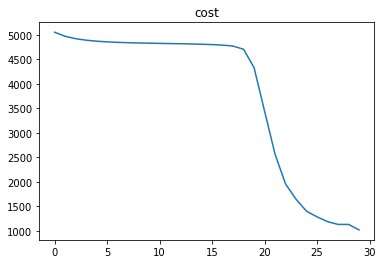

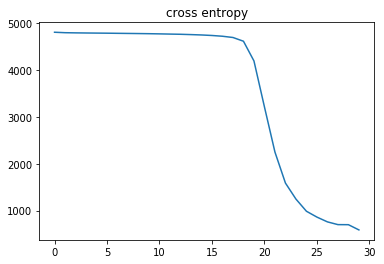

n_correct: 6881 n_total: 6963
train accuracy: 0.9882234668964527
n_correct: 615 n_total: 816
val accuracy: 0.7536764705882353


In [111]:
main(train, val, word2idx, dim=10, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=30)

In [115]:
model3 = load_model("./data/best_model.npz", T.tanh)
test3 = [t for t in test if t[3][-1] >=0]
val_score3 = model3.score(test3)
print(val_score3)

n_correct: 646 n_total: 816
0.7916666666666666


vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 30
decay_rate: 0.999
dim: 10
train_inner_nodes:  False
start training...
i: 0 cost: 5124.327333381943 xent 4872.577868049419 correct rate: 0.5228498438830542 time for epoch: 0:06:12.293321
n_correct: 416 n_total: 816
Saved best model
val accuracy: 0.5098039215686274 best val accuracy so far: 0.5098039215686274
i: 1 cost: 5034.941033884253 xent 4863.538657607507 correct rate: 0.5241271643485665 time for epoch: 0:06:24.605964
n_correct: 418 n_total: 816
Saved best model
val accuracy: 0.5122549019607843 best val accuracy so far: 0.5122549019607843
i: 2 cost: 4982.136937735728 xent 4859.731208607165 correct rate: 0.5271075787680953 time for epoch: 0:06:01.579713
n_correct: 421 n_total: 816
Saved best model
val accuracy: 0.5159313725490197 best val accuracy so far: 0.5159313725490197
i: 3 cost: 4947.895350959864 xent 4855.888549704742 correct rate: 0.5344876525688333 time for epoch: 0:06:56.188582
n_correct

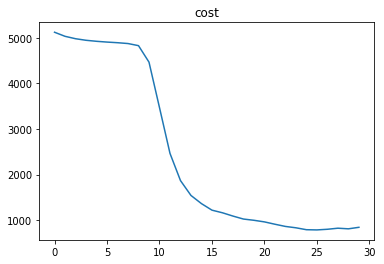

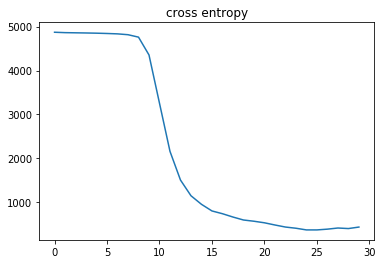

n_correct: 6981 n_total: 7046
train accuracy: 0.9907749077490775
n_correct: 618 n_total: 816
val accuracy: 0.7573529411764706


In [119]:
main(train, val, word2idx, dim=10, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=30)

In [121]:
model4 = load_model("./data/best_model.npz", T.tanh)
test4 = [t for t in test if t[3][-1] >=0]
val_score4 = model4.score(test4)
print(val_score4)

n_correct: 659 n_total: 816
0.8075980392156863


vocab size: 18647
learning rate: 0.008
regularization: 0.01
mu: 0
eps: 1e-07
epochs: 30
decay_rate: 0.999
dim: 10
train_inner_nodes:  False
start training...
i: 0 cost: 5270.705374443813 xent 5034.885023089322 correct rate: 0.5212736755421356 time for epoch: 0:07:11.184627
n_correct: 416 n_total: 816
Saved best model
val accuracy: 0.5098039215686274 best val accuracy so far: 0.5098039215686274
i: 1 cost: 5185.487347851899 xent 5021.260571815075 correct rate:ar: 5185.487348, xent so far: 5021.260572 0.5323908866318968 time for epoch: 0:06:26.815670
n_correct: 419 n_total: 816
Saved best model
val accuracy: 0.5134803921568627 best val accuracy so far: 0.5134803921568627
i: 2 cost: 5133.142263780324 xent 5008.138126423104 correct rate: 0.5444688443590447 time for epoch: 0:05:59.792360
n_correct: 427 n_total: 816
Saved best model
val accuracy: 0.5232843137254902 best val accuracy so far: 0.5232843137254902
i: 3 cost: 5068.421273488473 xent 4959.283073181819 correct rate: 0.5845457040900357

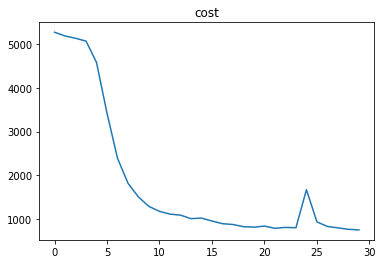

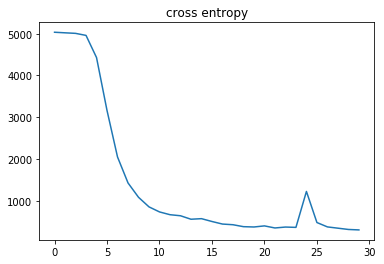

n_correct: 7251 n_total: 7286
train accuracy: 0.9951962668130662
n_correct: 644 n_total: 816
val accuracy: 0.7892156862745098


In [123]:
main(train, test, word2idx, dim=10, learning_rate=8e-3, reg=1e-2, mu=0, eps=1e-7, activation=T.tanh, epochs=30)

In [124]:
model5 = load_model("./data/best_model.npz", T.tanh)
test5 = [t for t in test if t[3][-1] >=0]
val_score5 = model5.score(test5)
print(val_score5)

n_correct: 674 n_total: 816
0.8259803921568627
